In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [3]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
# Гиперпараметры рынка
market_kwargs = dict(
    start_volumes=2,      # У всех фирм в резервах изначально 4 товара А и 10 товара Б
    base_price=50,         # Изначальные цены на рынке - 50 
    start_gains=500,       # Изначальные финансовые ресурсы у каждой фирмы - 500
    deprecation_steps=2,   # За сколько ходов износится основной капитал
    min_price=1,           # Минимальная возможная цена на рынке
    max_price=100          # Максимальная возможная цена на рынке
)

In [4]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]
# Инвестиционные функции
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
]

# Фирмы ориентируются чисто на финансовые ресурсы. Порядок ходов не перемешивается.

In [5]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=invest_functions,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3))

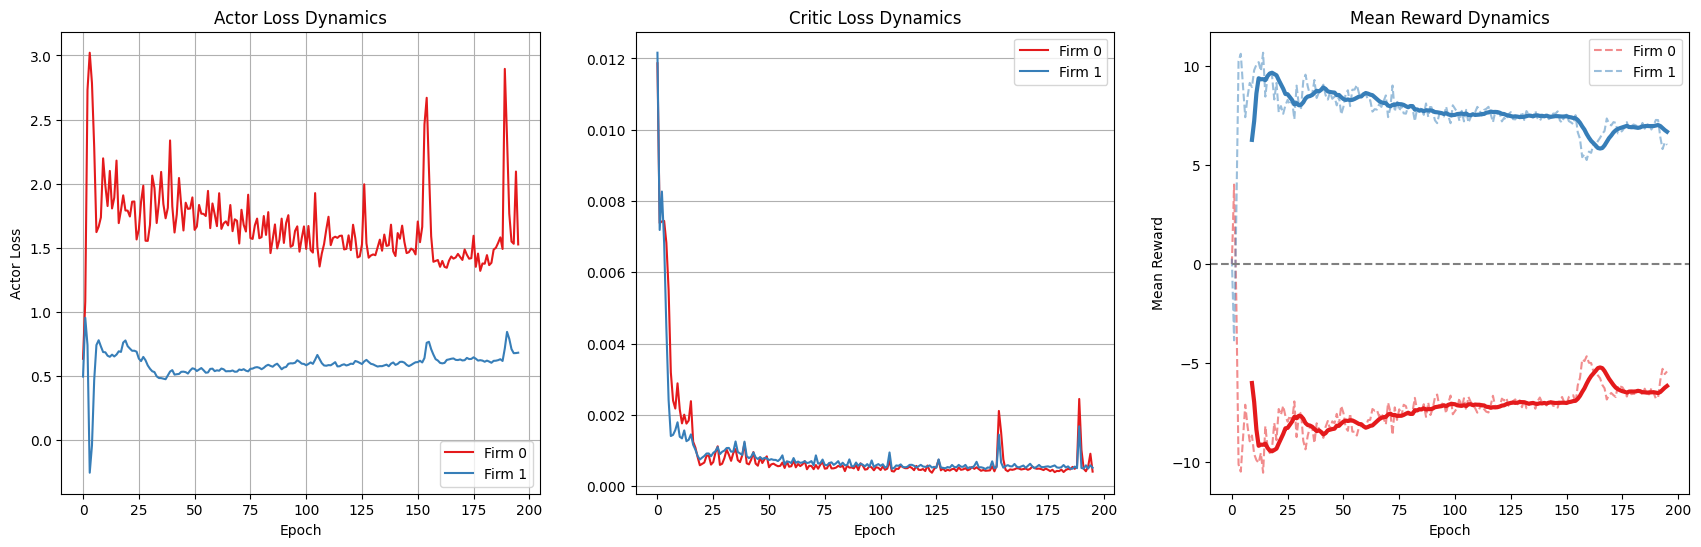

100%|█████████████████████████████████████| 200/200 [02:39<00:00,  1.26it/s, LR=0.000367, Buffer Index=262144, Order=[0, 1]]


In [6]:
# env.reset()
trainer.train(n_epochs=200,         # Количество эпох 
              episode_length=32,    # Сколько шагов походит каждая фирма до того, как среда перезапустится
              shuffle_order=False)  # Перемешивать ли порядок ходов от эпохи к эпохе

In [7]:
env.reset()
env.change_batch_size(1)  

In [8]:
n_periods = 64 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

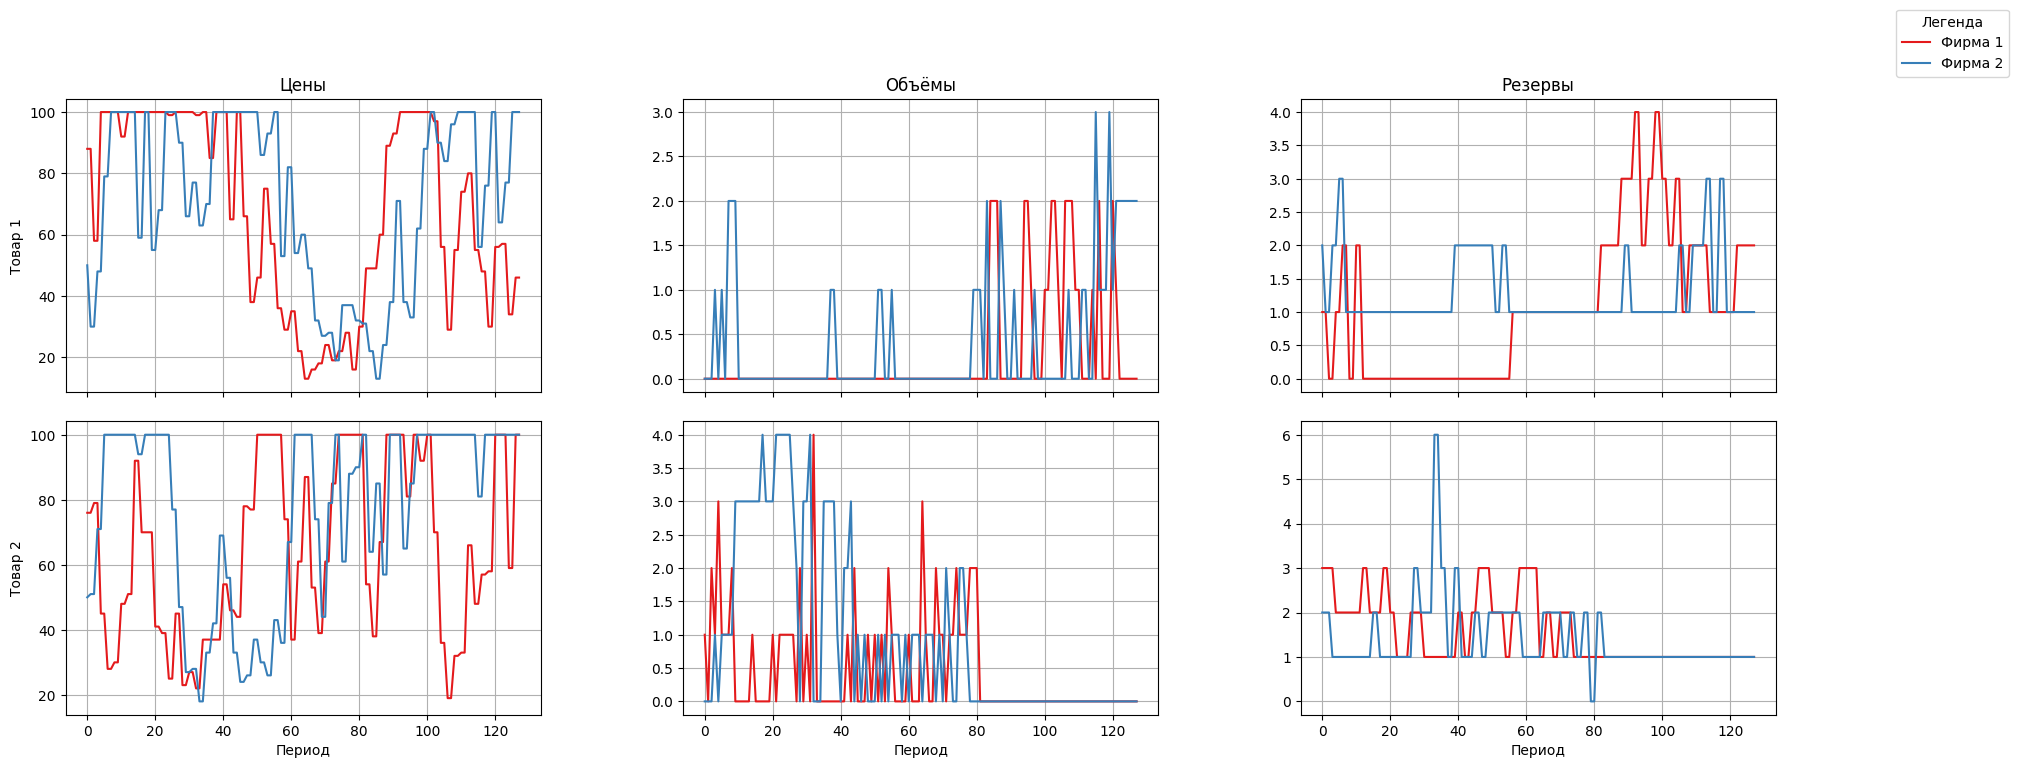

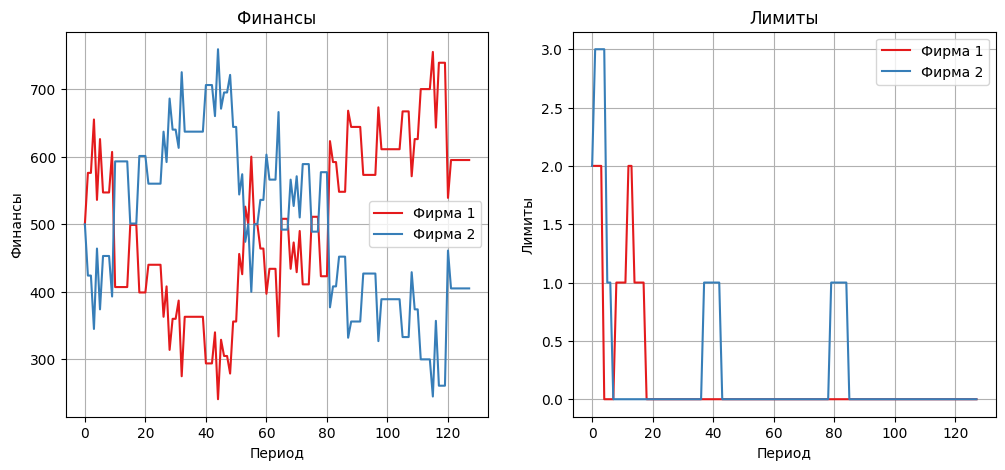

In [9]:
plot_environment(env.state_history)

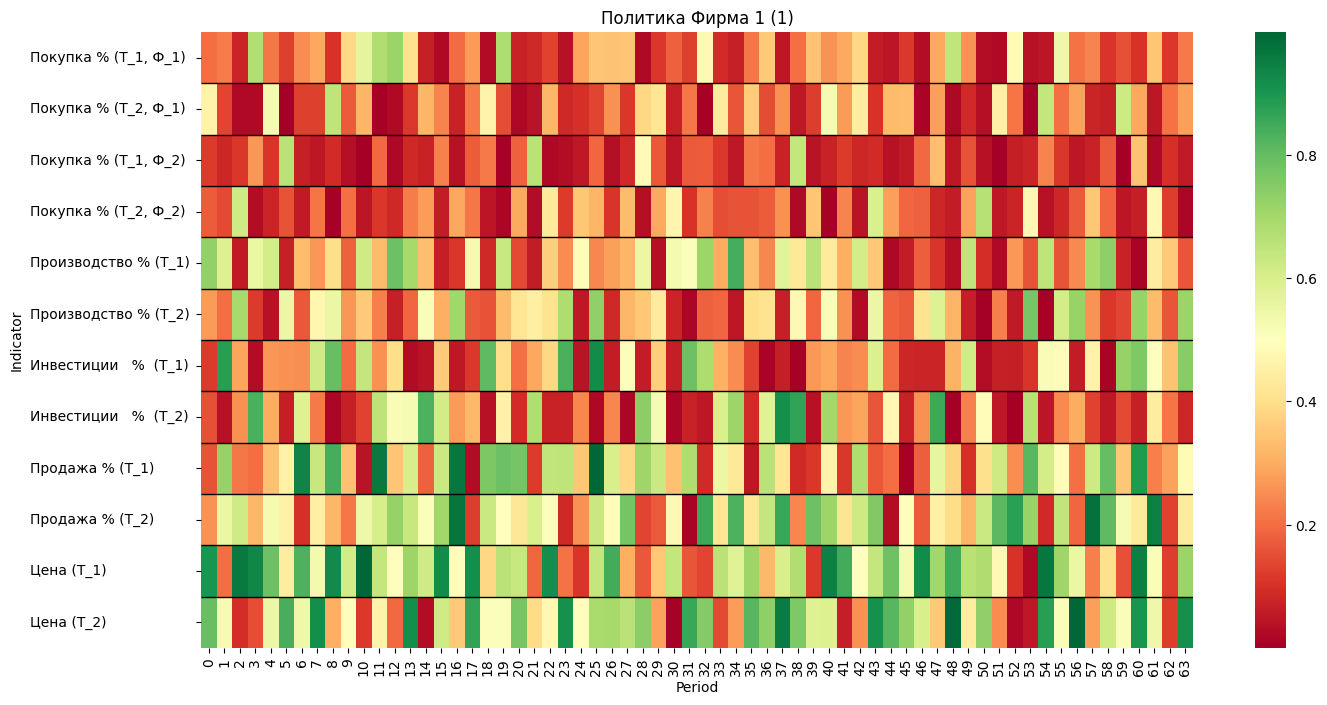

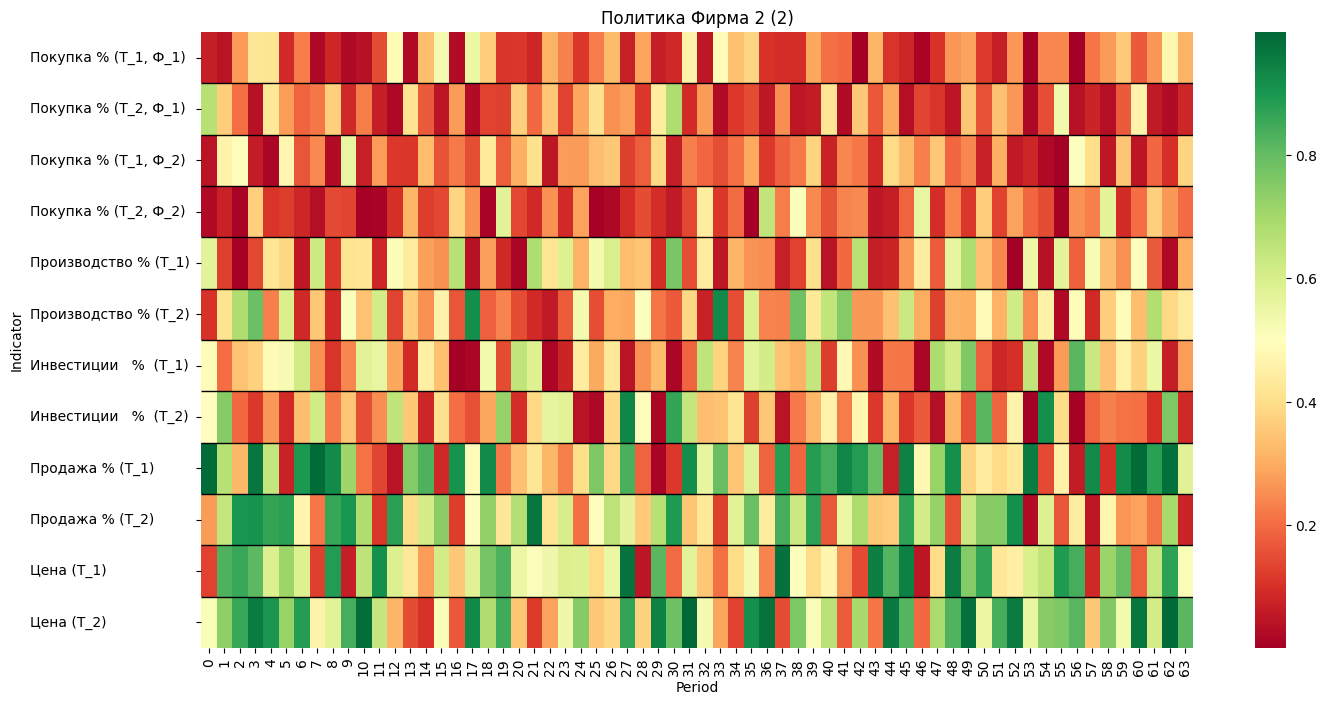

In [10]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

# Фирмы ориентируются чисто на финансы, порядок ходов перемешивается.

In [11]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]
# Инвестиционные функции
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
]

In [12]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=invest_functions,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3))

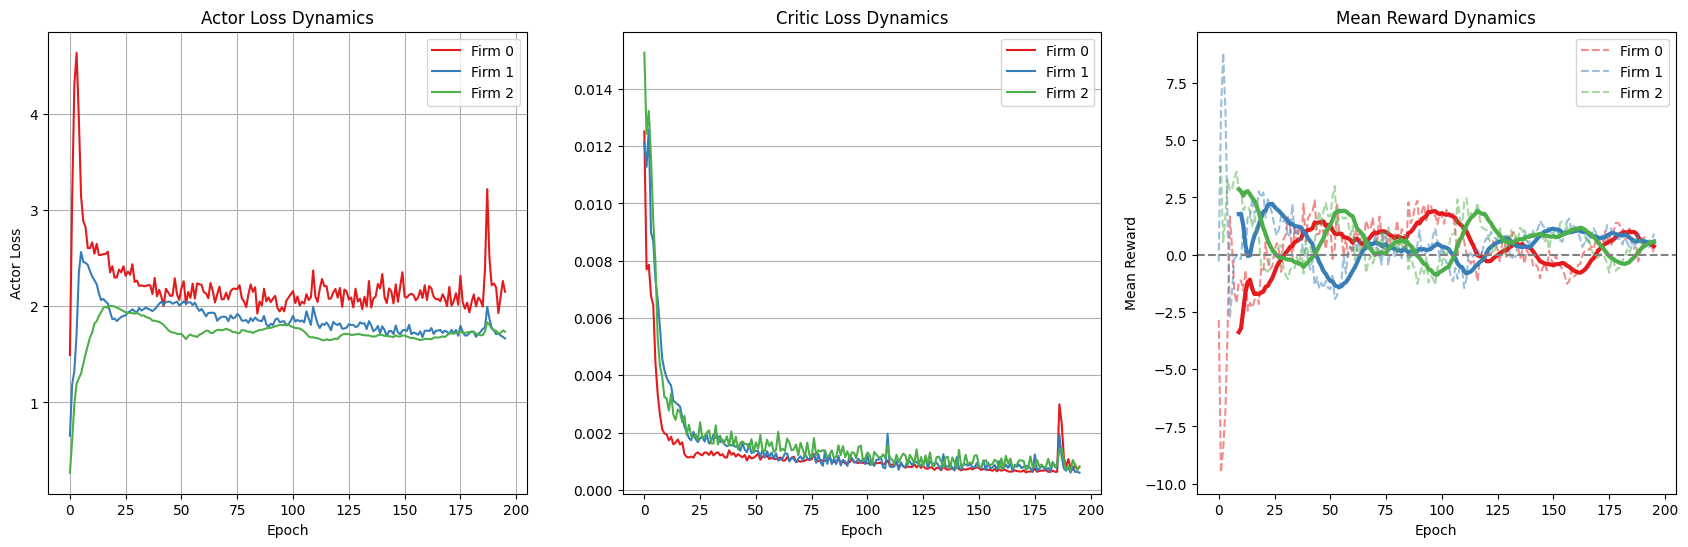

100%|██████████████████████████████████| 200/200 [04:20<00:00,  1.30s/it, LR=0.000367, Buffer Index=262144, Order=[1, 2, 0]]


In [13]:
trainer.train(n_epochs=200,
              episode_length=32,
              shuffle_order=True)

In [14]:
env.reset()
env.change_batch_size(1)  

In [15]:
n_periods = 64 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

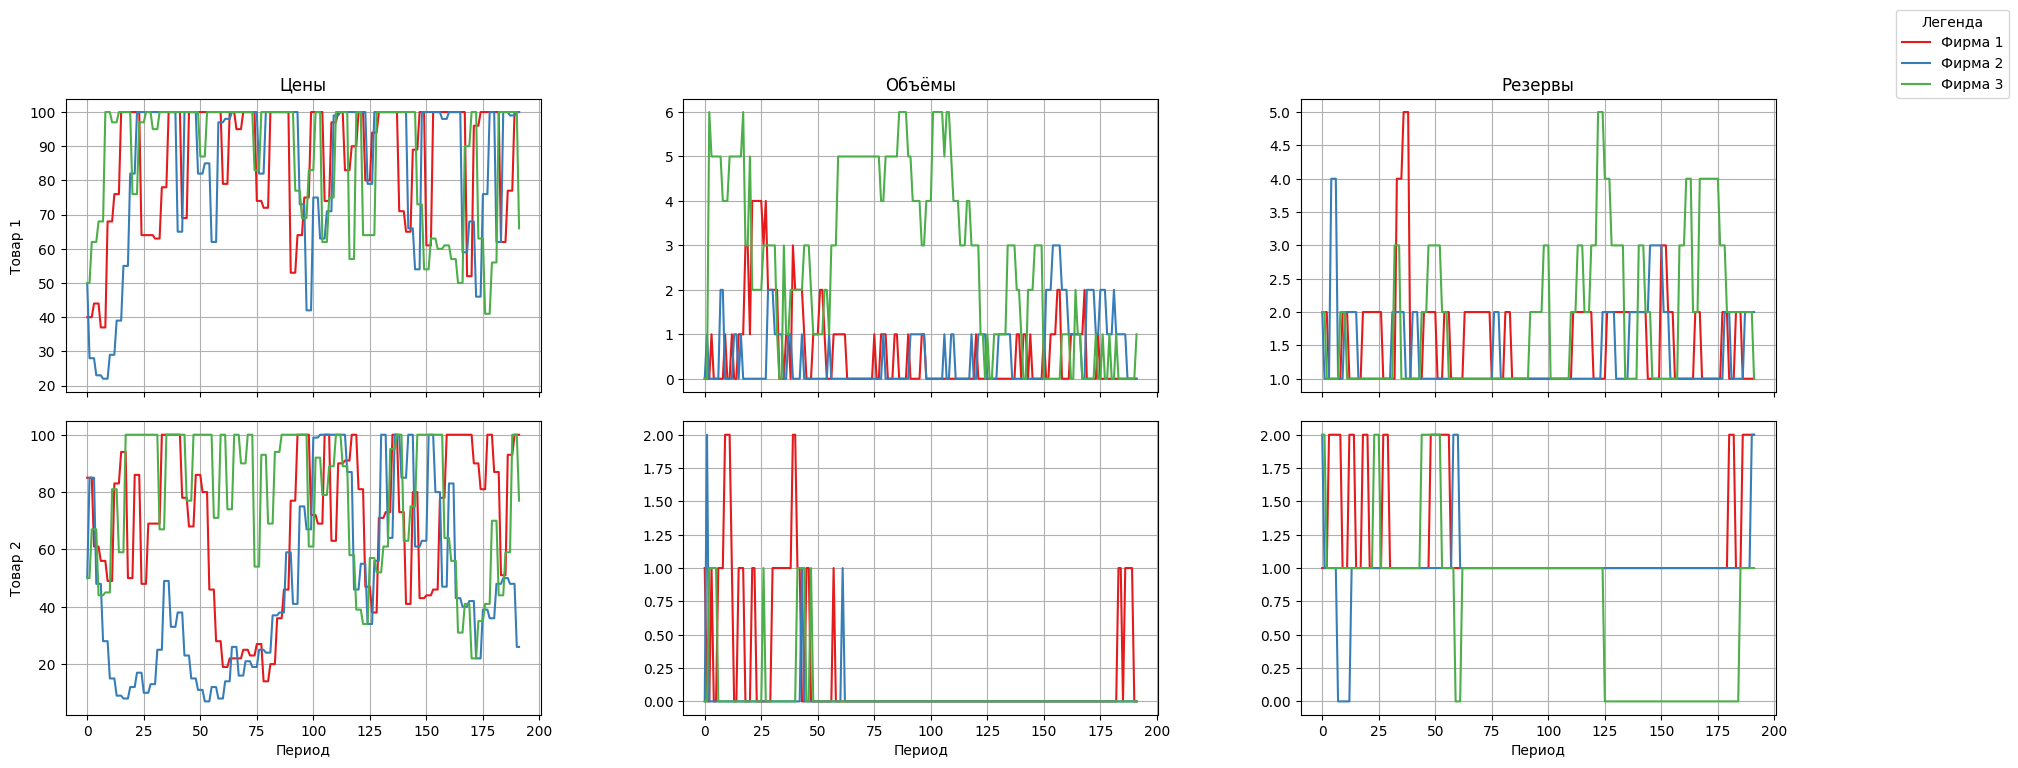

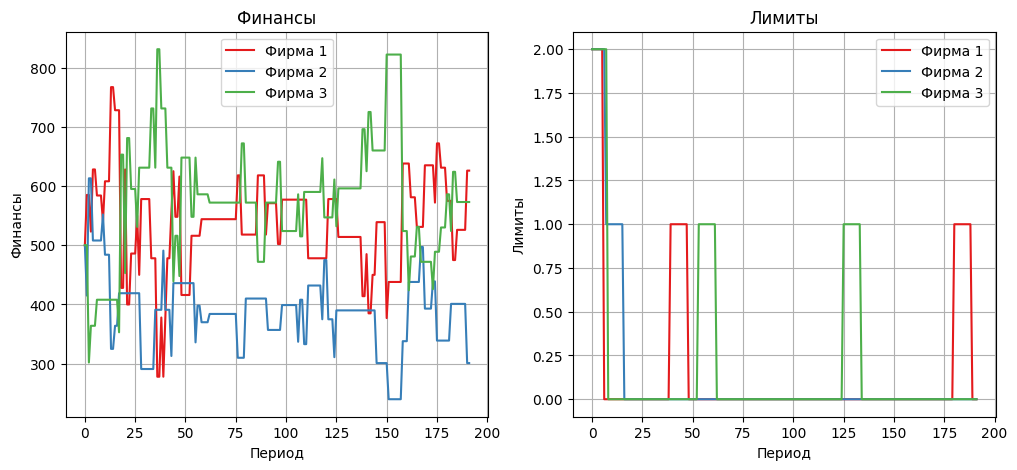

In [16]:
plot_environment(env.state_history)

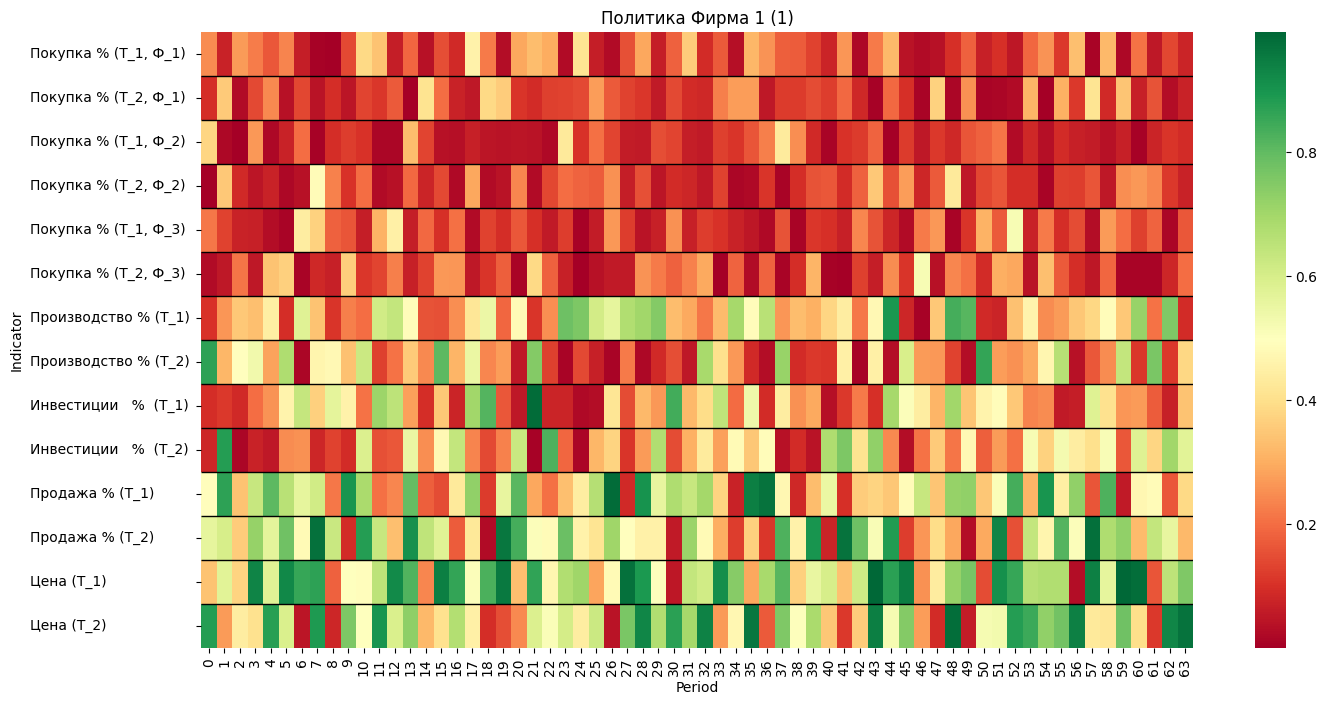

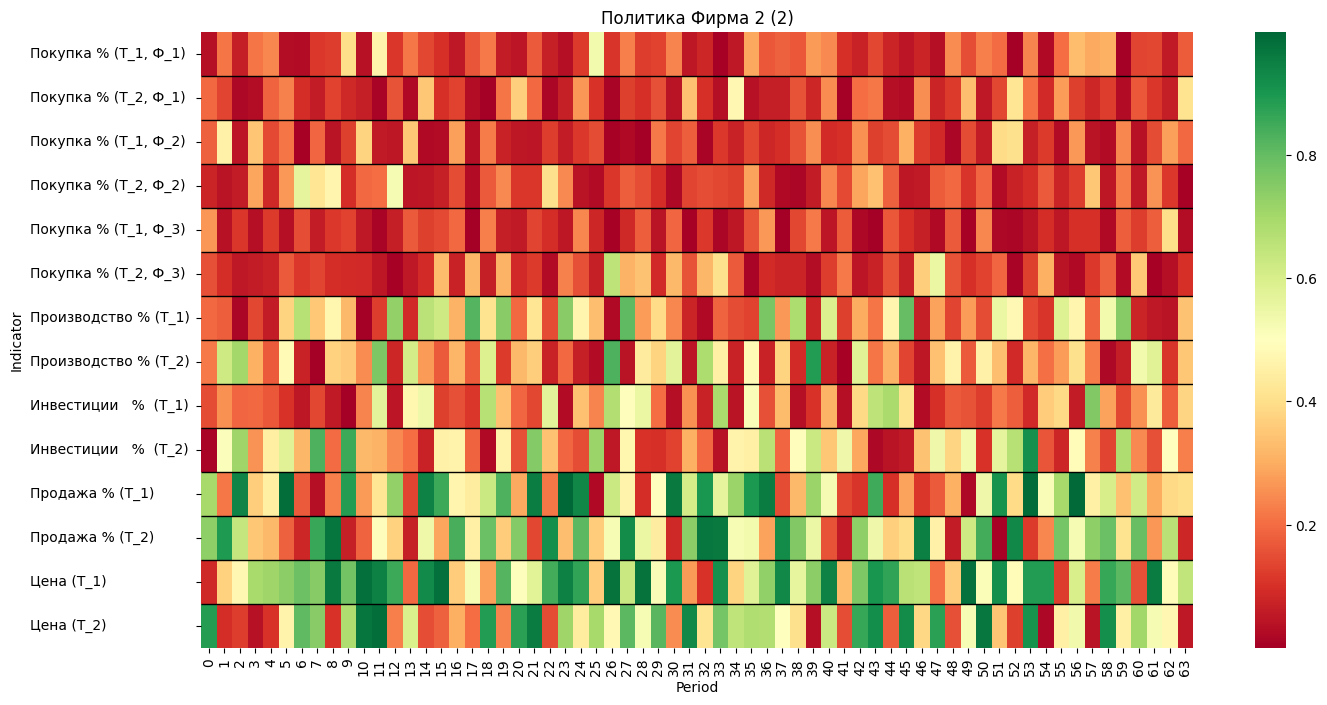

In [17]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

# Фирмы ориентируются чисто на финансы, больше фирм, разная эффективность

In [18]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([3, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([3, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]
# Инвестиционные функции
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device), 
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device), 
    BatchedLeontief(torch.tensor([2, 0]), torch.tensor(1), device=device),  
    BatchedLeontief(torch.tensor([0, 2]), torch.tensor(1), device=device), 
]

In [19]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=invest_functions,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3))

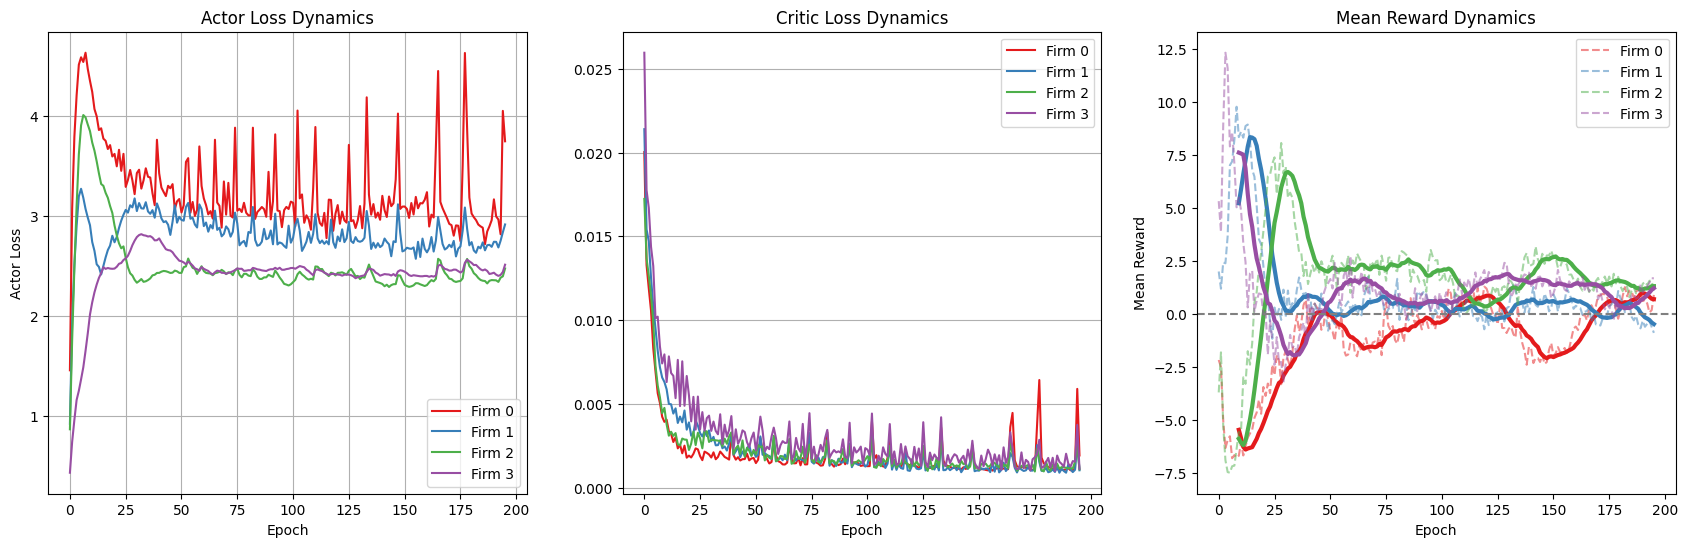

100%|███████████████████████████████| 200/200 [06:27<00:00,  1.94s/it, LR=0.000367, Buffer Index=262144, Order=[0, 2, 3, 1]]


In [20]:
trainer.train(n_epochs=200,
              episode_length=32,
              shuffle_order=True)

In [21]:
env.reset()
env.change_batch_size(1)  

In [22]:
n_periods = 32 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

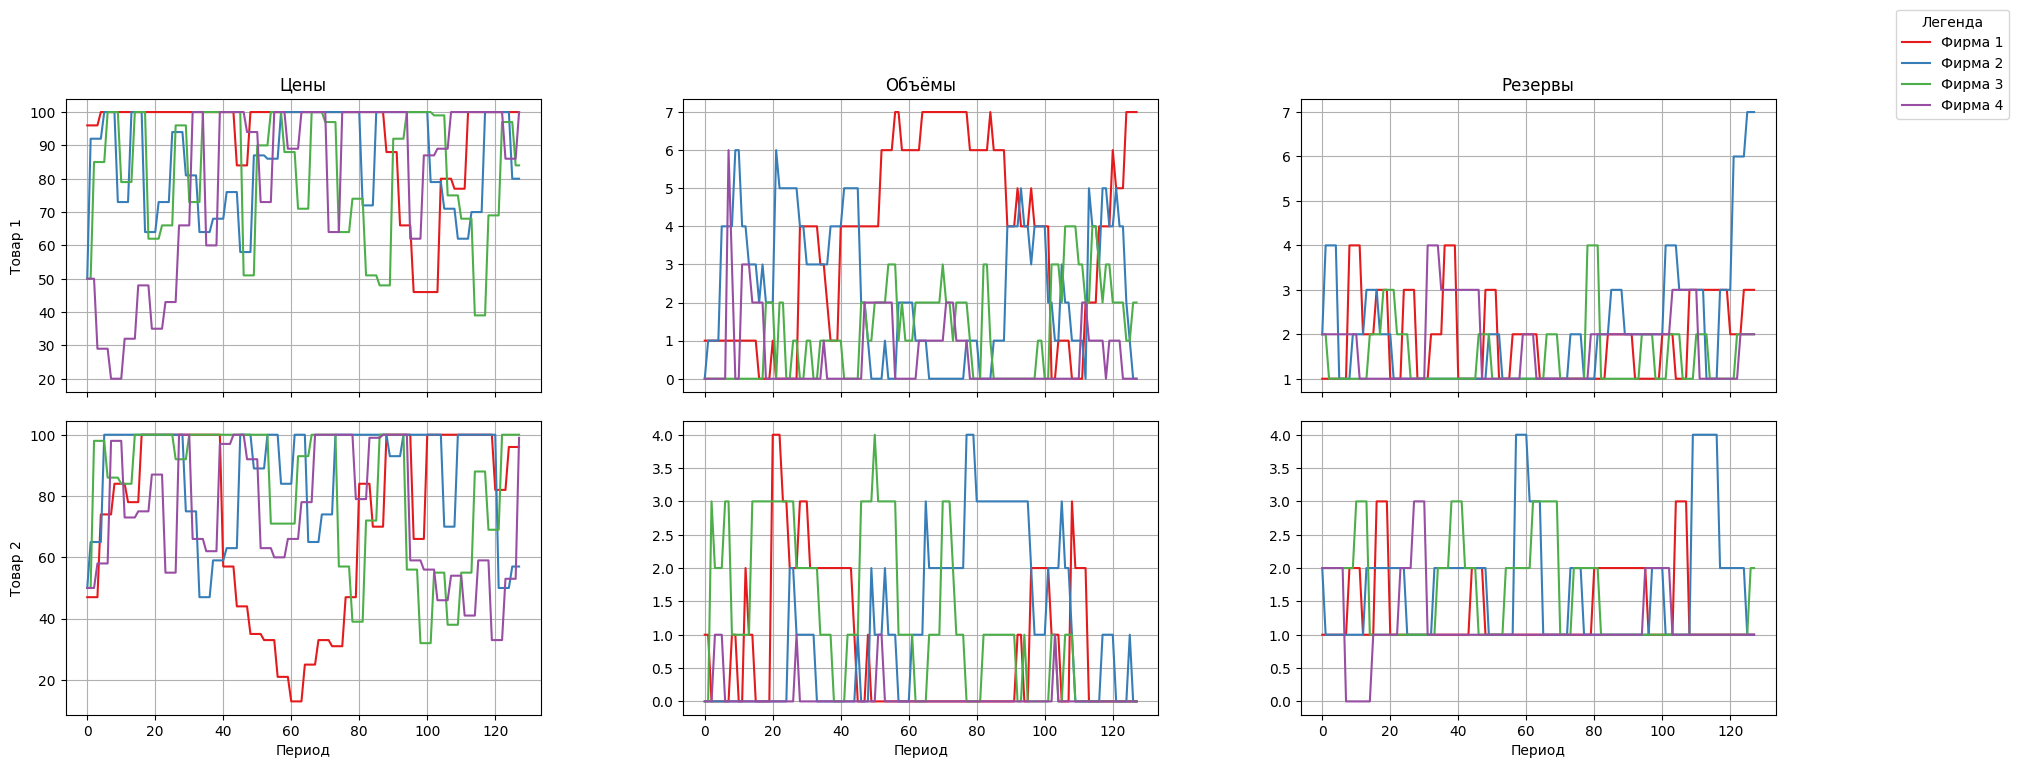

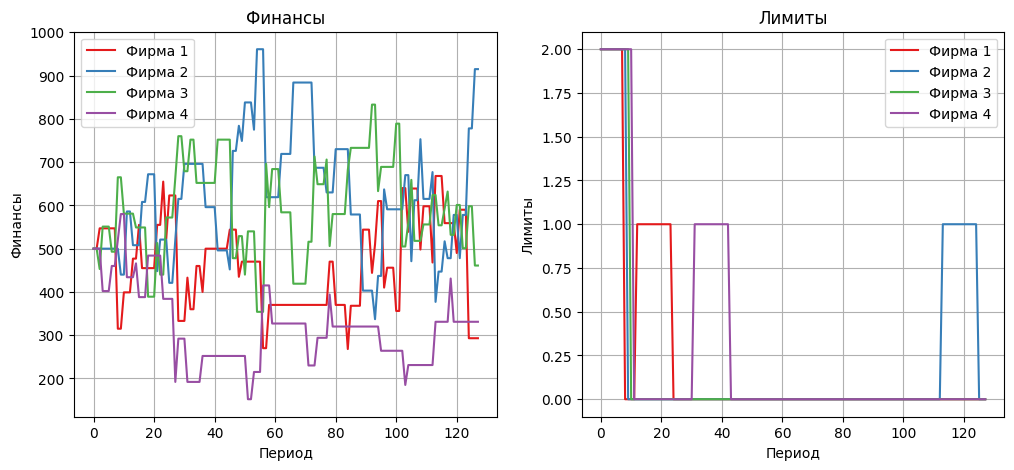

In [23]:
plot_environment(env.state_history)

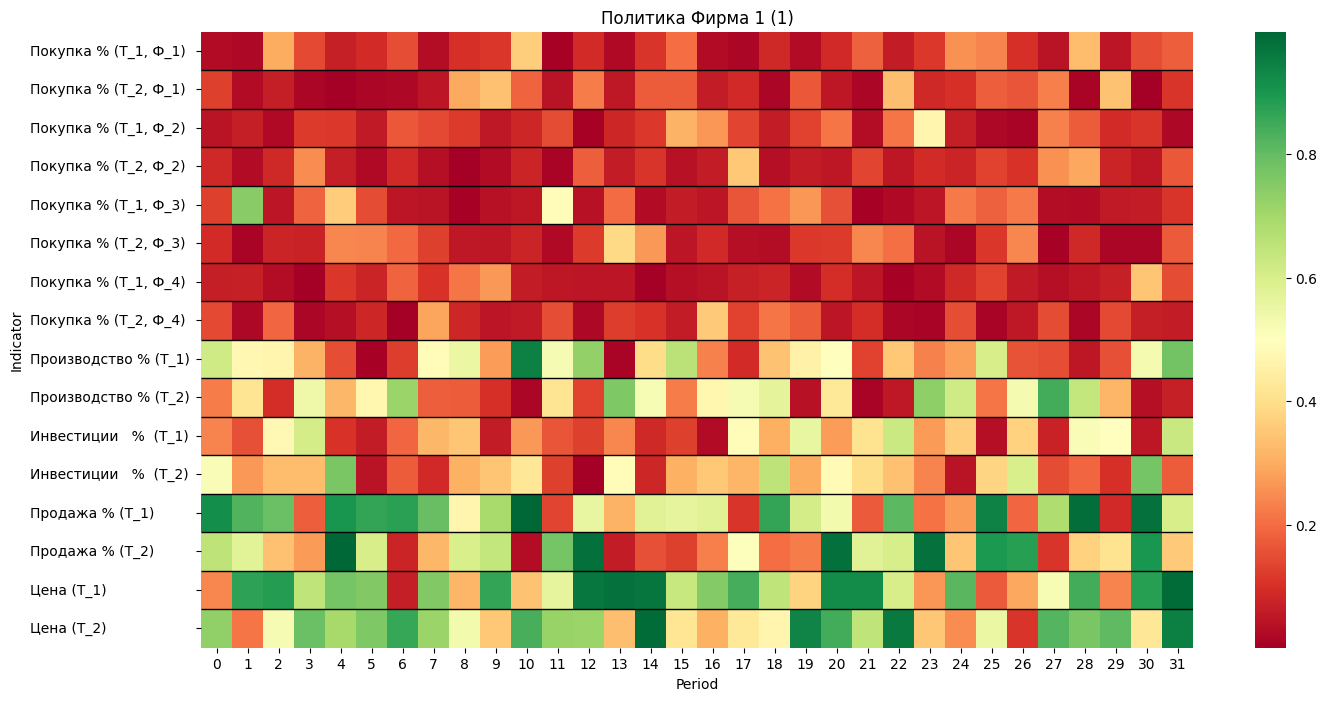

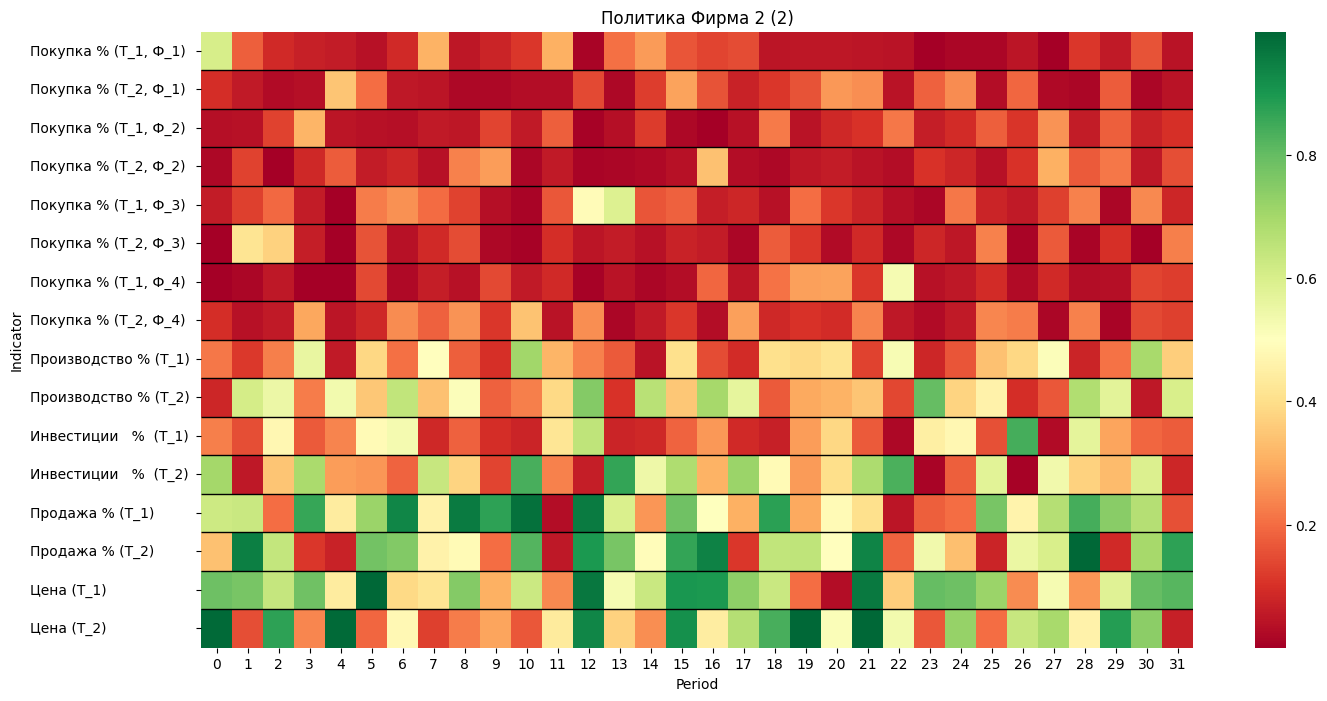

In [34]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

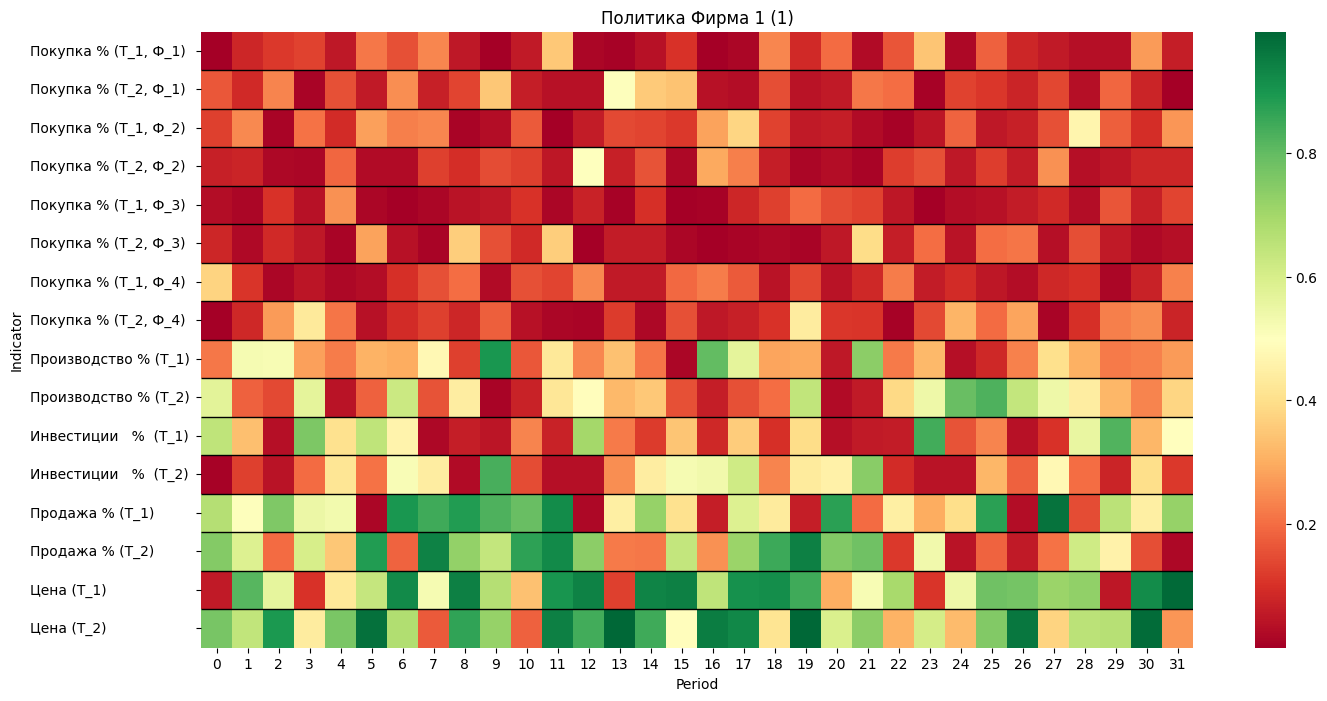

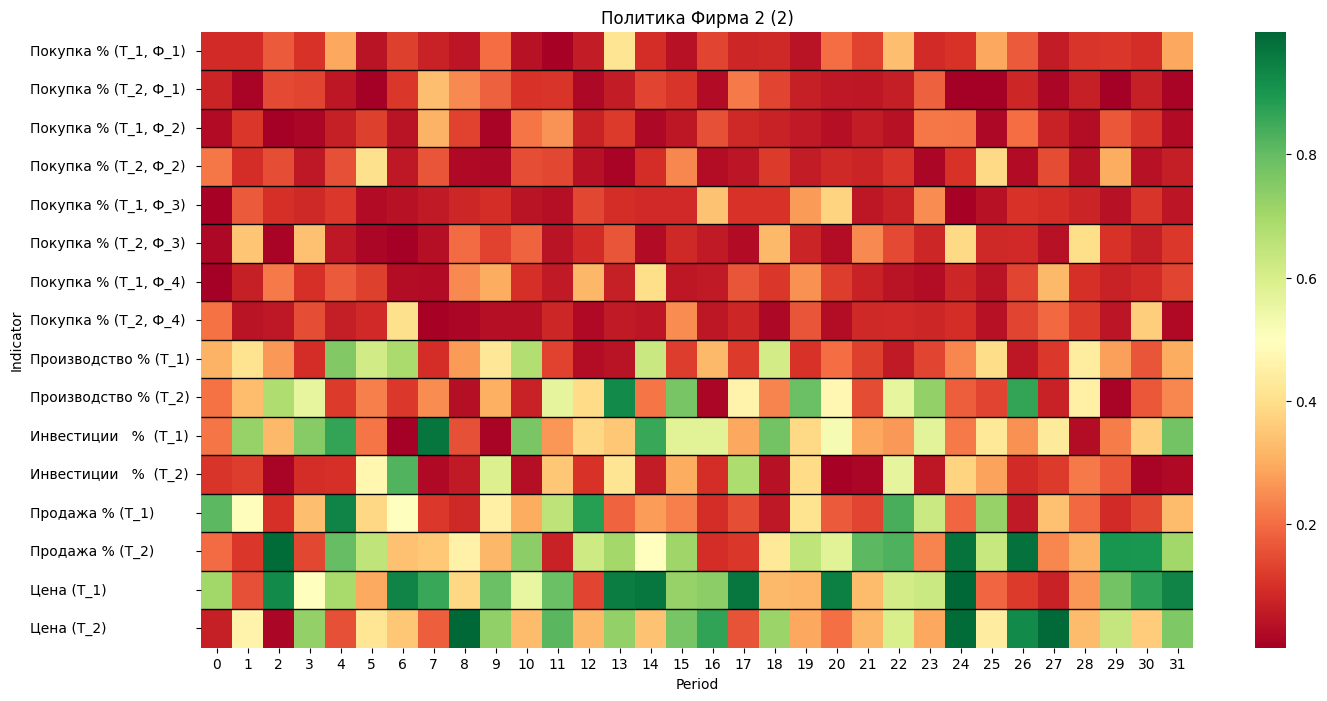

In [35]:
plot_actions(env.actions_history[2], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[3], 'Политика Фирма 2 (2)')